In [1]:
import os, json, glob, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.ndimage

sys.path.append('./pyusct/')
from rfdata import RFdata

%matplotlib inline


## parameters

In [36]:
# パラメータ設定保存
p = {
    "input": {
        "path" : "/mnt/nas/nb_usctsim/sim_005/",
        "offset": {
            "min": -100, 
            "max":100, 
            "interval":1
        }
    },
    
    "output" : {
        "path" : "/mnt/nas/PYUSCT_train/dataset008/",
        "num_sampling" : 10000,
        "radius":0,
        "sigma" : None
    }
}


In [37]:
sim_result_dirs = glob.glob( os.path.join(p["input"]["path"], "trial*"))
sim_result_dirs.sort()
sim_result_dirs = sim_result_dirs[:1]
sim_result_dirs

['/mnt/nas/nb_usctsim/sim_005/trial_001']

In [44]:
# 出力先ディレクトリ
out_dir = p["output"]["path"]
if not os.path.exists(out_dir): 
    os.makedirs(os.path.join(out_dir, "input"))   # 入力データ
    os.makedirs(os.path.join(out_dir, "output"))  # 出力データ      
    os.makedirs(os.path.join(out_dir, "sa"))      # 参照用SA

In [ ]:
with open(os.path.join(out_dir,"param.json"), 'w') as outf:
    json.dump(p, outf, indent=4)

## 教師データ生成

In [ ]:
offsets = np.arange(
    p["input"]["offset"]["min"],
    p["input"]["offset"]["max"], 
    p["input"]["offset"]["interval"])

def func_mask(rf):
    return (np.linalg.norm(rf.mesh_pos_rcv - rf.mesh_pos_src, axis=2) < rf.param["ringarray"]["radius"]*1.0 )*1

cnt = 0

with open(os.path.join(out_dir, "list.csv"), 'w') as outf: #
    outf.write('id,source,ix,iy,x,y\n')

    for sim_result_dir in sim_result_dirs:

        rf = RFdata(sim_result_dir)
        mask = rf.setTRmask(func_mask)

        r = rf.param["ringarray"]["radius"]*0.8
        x_min, y_min = rf.pos2ngrid( np.array([- r/np.sqrt(2), - r/np.sqrt(2)]))
        x_max, y_max = rf.pos2ngrid( np.array([+ r/np.sqrt(2), + r/np.sqrt(2)]))

        radius = p["output"]["radius"]
        sigma=p["output"]["sigma"]
        
        if sigma is not None:
            sct_img = scipy.ndimage.gaussian_filter(rf.medium_sct, sigma)
        else:
            sct_img = rf.medium_sct
            
        
        # 散乱体領域をすべて抽出（割合が小さいため）
        pos_pos = np.array(np.where(sct_img>0.0)).T
        for _ in range(p["output"]["num_sampling"]): # 出力画像内サンプリング

            if cnt % 2 == 0:
                iy, ix= pos_pos[np.random.randint(0, len(pos_pos)), :]
            else:
                ix = np.random.randint(x_min, x_max)
                iy = np.random.randint(y_min, y_max)

            out_image = sct_img[iy-radius:iy+radius+1, ix-radius:ix+radius+1]
            _, subset = rf.getPointSubset(np.array([iy, ix]), offsets)

            # partial SA
            mesh_grid = np.array(np.meshgrid( 
                    np.arange(iy - radius, iy+radius+1), 
                    np.arange(ix - radius, ix+radius+1) ))
            ngrids = mesh_grid.reshape(2, mesh_grid.size//2).T        
            def gridwise_summation(ngrid):
                _, subset = rf.getPointSubset(ngrid)
                return np.sum(subset)
            sa = np.array([gridwise_summation(ngrid) for ngrid in ngrids])
            sa = sa.reshape( mesh_grid[0].shape ).T
            assert out_image.shape == sa.shape

            np.save(os.path.join(os.path.join(out_dir,"input"), '{0:0>6}'.format(cnt)), subset)
            np.save(os.path.join(os.path.join(out_dir,"output"),'{0:0>6}'.format(cnt)), out_image)
            np.save(os.path.join(os.path.join(out_dir,"sa"),'{0:0>6}'.format(cnt)), sa)

            x, y = rf.ngrid2pos(np.array([iy, ix]))
            outf.write('{0},{1},{2},{3},{4},{5}\n'.format(cnt, sim_result_dir, ix,iy, x, y))

            cnt = cnt+1
            print(cnt)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


## 圧縮ファイル

In [ ]:
input_files = sorted(glob.glob( os.path.join(out_dir, "input/*.npy")))
output_files = sorted(glob.glob( os.path.join(out_dir, "output/*.npy")))
sa_files = sorted(glob.glob( os.path.join(out_dir, "sa/*.npy")))

assert len(input_files) == len(output_files) == len(sa_files)
L = len(input_files)
L

In [42]:
input_sample = np.load(input_files[0])
output_sample = np.load(output_files[0])
sa_sample = np.load(sa_files[0])

shape_i = input_sample.shape
shape_o = output_sample.shape
shape_s = output_sample.shape
shape_i, shape_o, shape_s

((16, 256, 200), (1, 1), (1, 1))

In [ ]:
input_all = np.zeros((L, shape_i[0], shape_i[1], shape_i[2]), dtype=input_sample.dtype)
output_all = np.zeros((L, shape_o[0], shape_o[1]), dtype=output_sample.dtype)
sa_all = np.zeros((L, shape_s[0], shape_s[1]), dtype=output_sample.dtype)

for i in range(L):
    input_sample = np.load(input_files[i])
    output_sample = np.load(output_files[i])
    sa_sample = np.load(sa_files[i])
    input_all[i,:,:,:] = input_sample
    output_all[i,:,:] = output_sample
    sa_all[i,:,:] = sa_sample

np.savez_compressed(
    os.path.join(out_dir, 'dataset'), 
    input_all=input_all,
    output_all=output_all,
    sa_all = sa_all
)

del(input_all)
del(output_all)

### Appendix

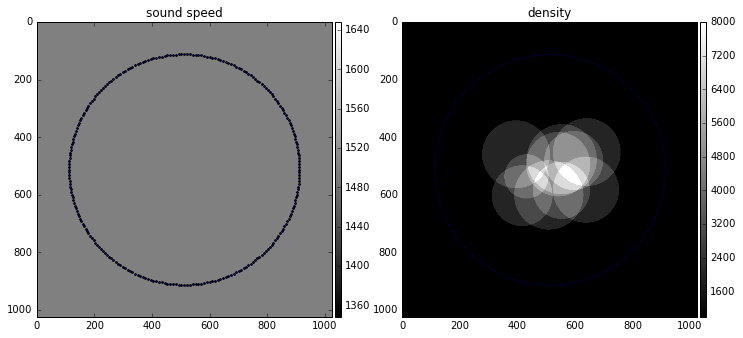

In [29]:
rf.draw_input()

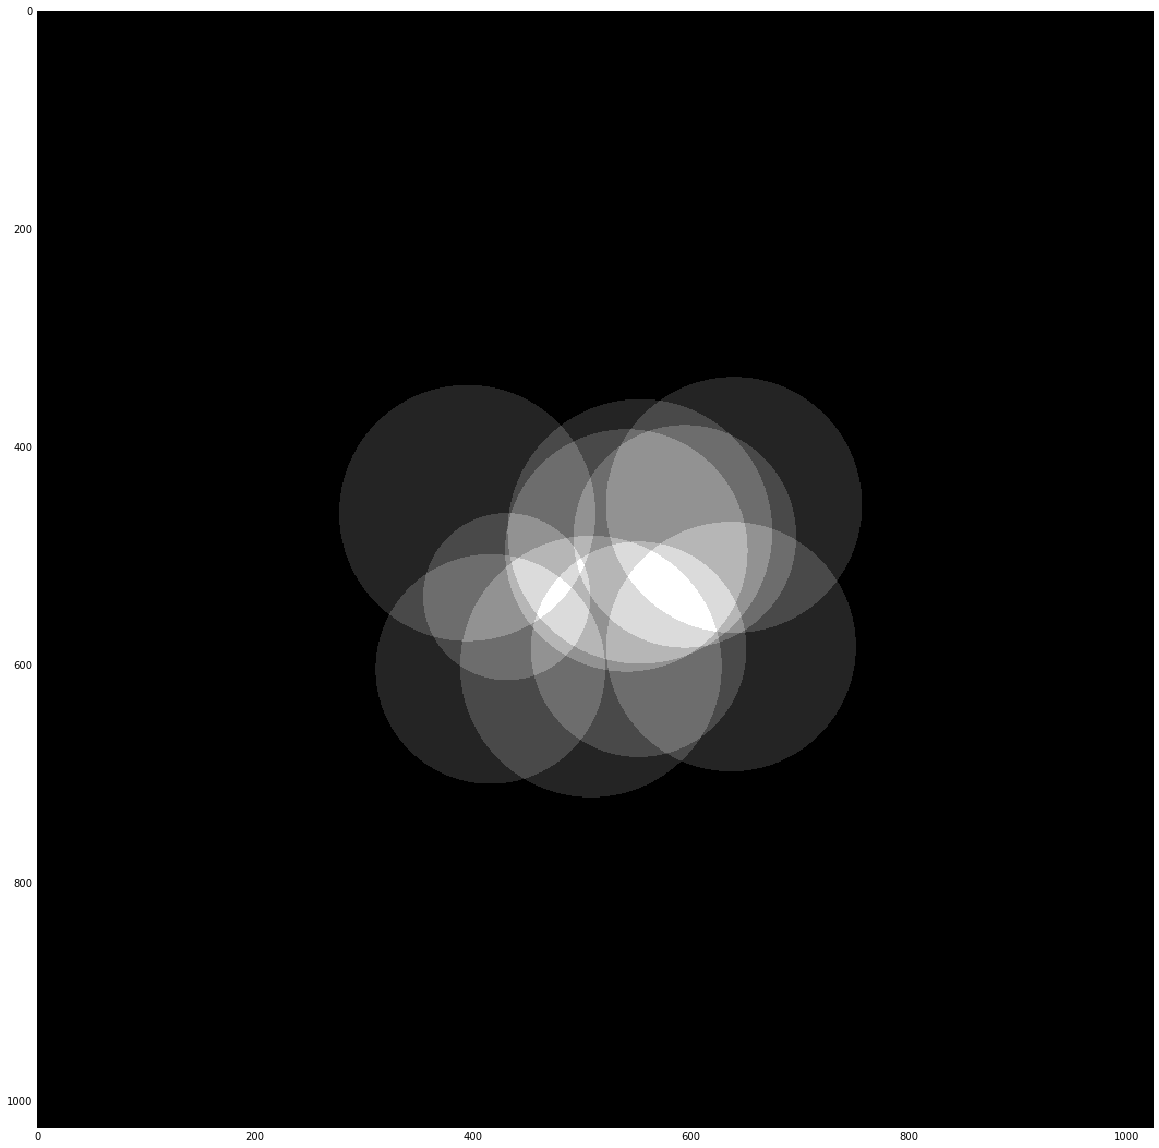

In [30]:
plt.figure(figsize=(20,20))
plt.imshow(rf.medium_imp, interpolation='nearest', cmap='gray')

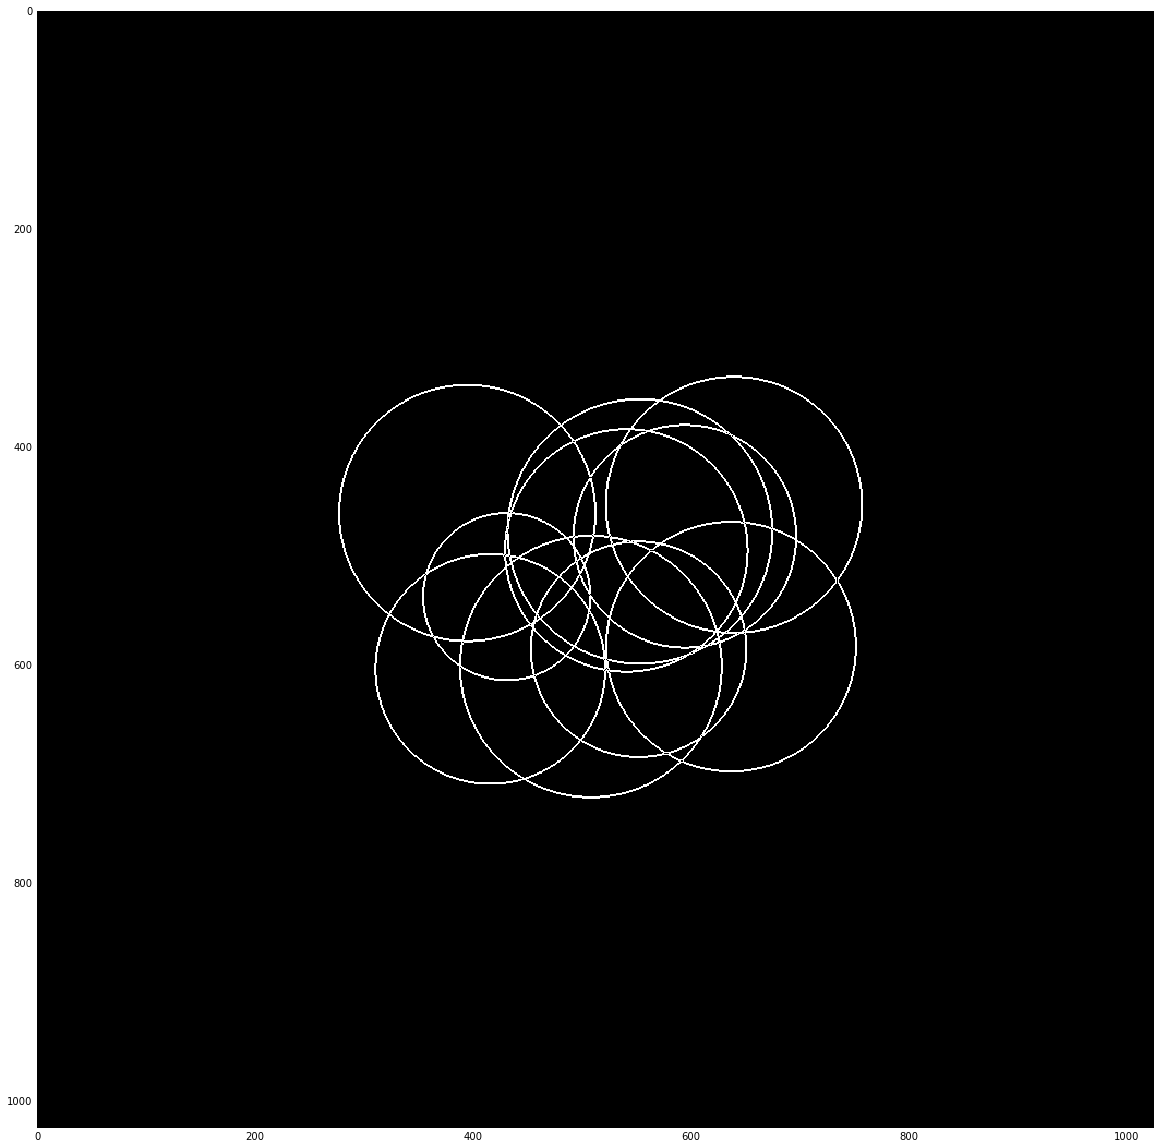

In [32]:
plt.figure(figsize=(20,20))
plt.imshow(rf.medium_sct, interpolation='nearest', cmap='gray')

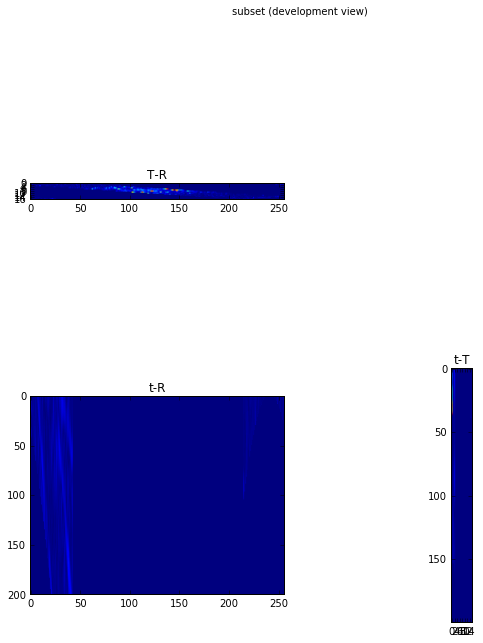

In [8]:
fig = plt.figure(figsize=(10,10))

fig.suptitle("subset (development view)")

plt.subplot(2,2,1)
plt.imshow(subset[:,:,0])
plt.title('T-R')

plt.subplot(2,2,3)
plt.imshow(subset[0,:,:].T)
plt.title('t-R')

plt.subplot(2,2,4)
plt.imshow(subset[:,0,:].T)
plt.title('t-T')

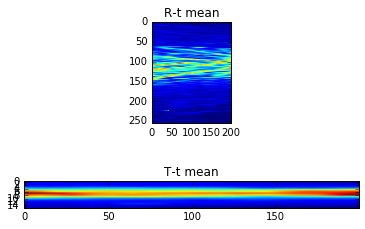

In [9]:
fig.suptitle("subset (1D mean reduction)")

plt.subplot(2,1,1)
plt.imshow(np.mean( subset, axis=0 ))
plt.title('R-t mean')

plt.subplot(2,1,2)
plt.imshow(np.mean(subset, axis=1))
plt.title('T-t mean')

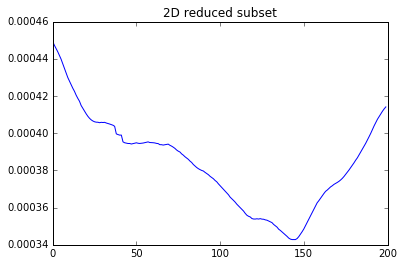

In [10]:
plt.plot(np.mean(np.mean(subset, axis=0), axis=0))
plt.title("2D reduced subset")